In [11]:
%matplotlib inline
import pylab
import numpy as np
import functools
import adapt_float
import adapt_spike
import adapt_fixed_small

import ctn_benchmark.control as ctrl

In [72]:
def objective(args, adapt_type):
    D = 1
    dt=0.001
    T = 20.0
    seed=2
    noise=0.1
    Kp=args['Kp']
    Kd=args['Kd']
    Ki=args['Ki']
    print 'trying', Kp, Kd, Ki
    tau_d=0.001
    period=4
    amplitude=1
    n_neurons=500
    learning_rate=1
    max_freq=1.0
    synapse=0.01
    scale_add=2
    delay=0.01
    filter=0.01

    n_neurons=256

    signal = ctrl.Signal(D, period, dt=dt, max_freq=max_freq, seed=seed)

    system = ctrl.System(D, D, dt=dt, seed=seed,
            motor_noise=noise, sense_noise=noise,
            scale_add=scale_add,
            motor_scale=10,
            motor_delay=delay, sensor_delay=delay,
            motor_filter=filter, sensor_filter=filter)

    pid = ctrl.PID(Kp, Kd, Ki, tau_d=tau_d)
    
    if adapt_type == 'float':
        adapt = adapt_float.AdaptiveFloat(n_inputs=D, n_outputs=D, n_neurons=n_neurons, seed=seed,
                                     learning_rate=1e-4)
        scale = 1.0
    elif adapt_type == 'fixed':
        adapt = adapt_fixed_small.AdaptiveFixed(n_inputs=D, n_outputs=D, n_neurons=n_neurons, seed=seed,
                                                input_bits=8,
                                                state_bits=8,
                                                extra_bits=4,
                                                decoder_offset=4,
                                                decoder_bits=8,
                                                smoothing=10,
                                                learning_rate=1e-4)
        scale = adapt.input_max
    else:
        adapt = None

    steps = int(T / dt)
    time = np.arange(steps)*dt
    data_desired = np.zeros((steps, D))
    data_actual = np.zeros((steps, D))
    data_pid = np.zeros((steps, D))
    data_error = np.zeros((steps, D))

    for i in range(steps):
        desired = signal.value(i*dt)*amplitude
        data_desired[i,:] = desired

        actual = system.state
        data_actual[i,:] = actual

        raw_pid = pid.step(actual, desired)
        data_pid[i,:] = raw_pid

        if adapt is not None:
            adjust = adapt.step(actual*scale, -raw_pid*scale)/scale
        else:
            adjust = 0
            
        system.step(raw_pid + adjust)
        
    #pylab.plot(data_desired)
    #pylab.plot(data_actual)
        
    rmse = np.sqrt(np.mean((data_desired - data_actual)**2))
        
    return dict(
        status='ok',
        loss=rmse
        )


In [59]:
objective(dict(Kp=10, Kd=2, Ki=0), adapt_type='none')

trying 10 2 0


{'loss': 0.072578950102291276, 'status': 'ok'}

In [73]:
objective(dict(Kp=10, Kd=2, Ki=0), adapt_type='fixed')

trying 10 2 0


{'loss': 0.065557196457235914, 'status': 'ok'}

In [61]:
objective(dict(Kp=10, Kd=2, Ki=0), adapt_type='float')

trying 10 2 0


{'loss': 0.059855123871354471, 'status': 'ok'}

In [42]:
import hyperopt as hp

space = dict(
    Kp=hp.hp.lognormal('Kp', np.log(50), 1),
    Kd=hp.hp.lognormal('Kd', np.log(20), 1),
    Ki=hp.hp.lognormal('Ki', np.log(10), 1)
)

trials = hp.Trials()



In [54]:
import functools
best = hp.fmin(functools.partial(objective, adapt_type='none'), space=space, algo=hp.tpe.suggest, max_evals=100, trials=trials)

trying 114.770987149 52.1093915339 34.523488315
trying 96.4564007286 8.94229157721 56.043252455
trying 146.393044894 22.2700142553 22.5102762544
trying 120.722168015 10.6342010579 10.4477337723
trying 296.980700034 21.5485290052 1.79378050616
trying 46.3596483055 43.4751578719 18.0655530425
trying 20.0025367749 34.6281892575 16.1782020117
trying 50.4005204591 33.4906747566 11.2156598723
trying 153.104519669 193.198823397 11.0467677988
trying 13.3916328139 16.551889787 32.9095297298
trying 12.1989544865 16.0317310375 138.635094794
trying 5.02679451709 14.4944484188 2.41750728437
trying 12.276807354 17.6464522014 0.759984221527
trying 14.2193810661 1.33140824233 2.70733666952
trying 7.15373973008 12.8073107368 77.3326922421
trying 16.0016607829 18.5604224371 33.9580068995
trying 1.23732563249 15.9709077005 1.33547699772
trying 9.61402483544 12.9619480359 3.53599541915
trying 15.8860748834 15.8714309145 29.3937545919
trying 4.96897501295 19.6898963023 0.819059912742
trying 38.0989784861 1

In [55]:
best

{'Kd': 16.477740282991654, 'Ki': 12.162652176904626, 'Kp': 13.842995093163033}

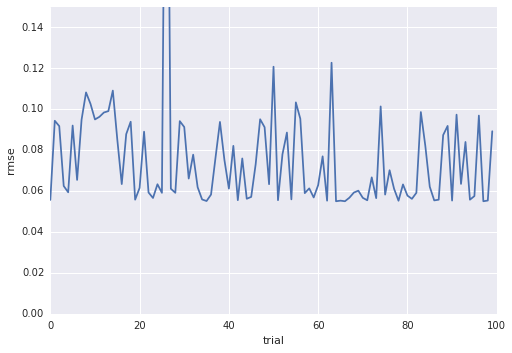

best rmse 0.0550078106508


In [99]:
loss = [t['result']['loss'] for t in trials.trials]
pylab.plot(loss)
pylab.xlabel('trial')
pylab.ylabel('rmse')
pylab.ylim(0, 0.15)
pylab.show()
print 'best rmse', np.min(loss)

In [93]:
limits = [1.0, 1.05, 1.1, np.inf]
limit_labels = ['<5%', '5-10%', '10%+']
best_rmse = np.min(loss)
data = []
for t in trials.trials:
    d = {}
    d['Kp'] = t['misc']['vals']['Kp'][0]
    d['Kd'] = t['misc']['vals']['Kd'][0]
    d['Ki'] = t['misc']['vals']['Ki'][0]
    rate = t['result']['loss'] / best_rmse
    index = 0
    while limits[index+1] < rate:
        index += 1
    d['category'] = limit_labels[index]
    
    data.append(d)


In [94]:
import pandas
import seaborn as sns

In [95]:
df = pandas.DataFrame(data)

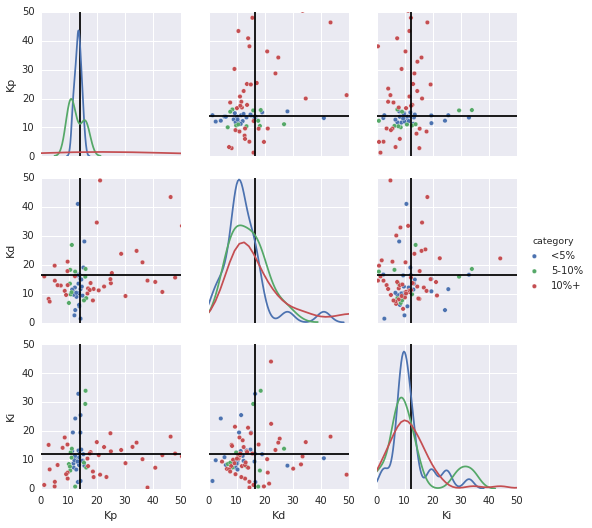

In [97]:
grid = sns.pairplot(data=df, x_vars=['Kp', 'Kd', 'Ki'], y_vars=['Kp', 'Kd', 'Ki'], diag_kind='kde', hue='category', hue_order=limit_labels)
ax_lim=50
for i, row in enumerate(grid.axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.set_xlim(0, ax_lim)
        else:
            ax.set_xlim(0, ax_lim)
            ax.set_ylim(0, ax_lim)
        
best_vals = best['Kp'], best['Kd'], best['Ki']
for i, row in enumerate(grid.axes):
        for j, ax in enumerate(row):
            if i==j:
                ax.axvline(best_vals[i], c='k')
            else:
                ax.axvline(best_vals[j], c='k')
                ax.axhline(best_vals[i], c='k')            